# Introduction to graphs and shortest paths problems
## Introduction to networkx

In [14]:
import networkx as nx

There are many ways to feed nodes and edges to a graph.
Nodes may be of any type as long as it is [hashable](https://docs.python.org/3/glossary.html) (lists are not allowed since they can be modified by side effects).

In [15]:
g = nx.Graph()
g.add_node("spam")
# a node is created if it does not exist when you create an edge
g.add_edge(1, 2)

g.nodes, g.edges

(NodeView(('spam', 1, 2)), EdgeView([(1, 2)]))

There are several ways to display graphs. You may explore different possibilities in the documentation. We will mostly use the matplotlib output in this notebook. The layout of the graph is done automatically, but you can select another one with the `pos` parameter of `draw_networkx`.

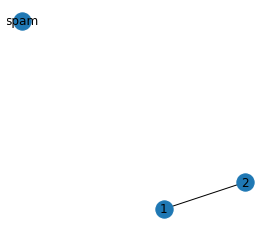

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.axes()
ax.set_axis_off()
ax.set_aspect(1)
nx.draw_networkx(g, ax=ax)

### Directed graphs, weighted graphs

You may create undirected (`Graph`) or directed (`DiGraph`) graphs. For convenience sake, you may feed an adjacency list directly when constructing the graph.

For a weighted graph, just add the corresponding parameter to the edge. The bracket notation returns an edge as a dictionary with all the parameters given at creation.

{'weight': 5}

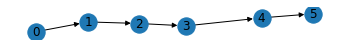

In [17]:
g = nx.DiGraph()

# create edges from an iterable
g.add_edges_from(
    zip([0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5]),
    # you may add weights to edges just naturally
    weight=5,
)

ax = plt.axes()
ax.set_axis_off()
ax.set_aspect(1)
nx.draw_networkx(g, ax=ax)

g[0][1]

OutEdgeView([('A', 'A'), ('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'F'), ('C', 'A'), ('C', 'E'), ('C', 'F'), ('D', 'B'), ('E', 'A')])

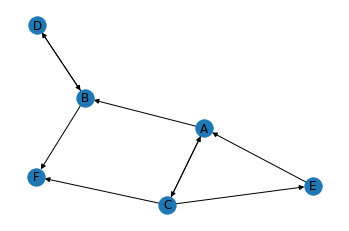

In [19]:
# %load solutions/create_graph.py
g = nx.DiGraph(
    # feed an adjacency list
    [
        ['A', 'A'], ['A', 'B'], ['A', 'C'],
        ['B', 'D'], ['B', 'F'],
        ['C', 'A'], ['C', 'E'], ['C', 'F'],
        ['D', 'B'],
        ['E', 'A'],
    ]
)

ax = plt.axes()
ax.set_axis_off()

# You may give a positioning strategy
nx.draw_networkx(g, ax=ax, pos=nx.kamada_kawai_layout(g))
g.edges


Graphs are provided with methods and properties that were defined in class.

In [20]:
# the adjacency list for the graph
g.adj

AdjacencyView({'A': {'A': {}, 'B': {}, 'C': {}}, 'B': {'D': {}, 'F': {}}, 'C': {'A': {}, 'E': {}, 'F': {}}, 'D': {'B': {}}, 'F': {}, 'E': {'A': {}}})

In [21]:
# the edges leaving from A
g['A']

AtlasView({'A': {}, 'B': {}, 'C': {}})

In [22]:
# the degree of node A
g.degree['A']

6

In [23]:
g.is_directed()

True

In [24]:
# you may create the undirected version of a directed graph
g_undirected = g.to_undirected()
# and compare the adjacency lists
g_undirected.adj

AdjacencyView({'A': {'A': {}, 'B': {}, 'C': {}, 'E': {}}, 'B': {'A': {}, 'D': {}, 'F': {}}, 'C': {'A': {}, 'E': {}, 'F': {}}, 'D': {'B': {}}, 'F': {'B': {}, 'C': {}}, 'E': {'C': {}, 'A': {}}})

## Shortest paths problems

The `networkx` library contains many graph algorithms implementations.

In [25]:
import pkgutil
list(module for _, module, is_package in pkgutil.iter_modules(nx.algorithms.__path__)
     if is_package)

['approximation',
 'assortativity',
 'bipartite',
 'centrality',
 'coloring',
 'community',
 'components',
 'connectivity',
 'flow',
 'isomorphism',
 'link_analysis',
 'node_classification',
 'operators',
 'shortest_paths',
 'tests',
 'traversal',
 'tree']

### Basic introduction to Dijkstra algorithm

We will focus in this session on shortest paths problems. Let us consider the following graph we studied in class.

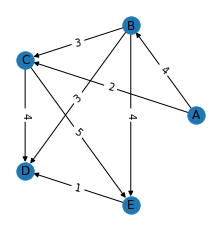

In [26]:
g = nx.DiGraph()

g.add_edge('A', 'B', weight=4)
g.add_edge('A', 'C', weight=2)
g.add_edge('B', 'C', weight=3)
g.add_edge('B', 'D', weight=3)
g.add_edge('B', 'E', weight=4)
g.add_edge('C', 'D', weight=4)
g.add_edge('C', 'E', weight=5)
g.add_edge('E', 'D', weight=1)

ax = plt.axes()

nx.draw_networkx(
    g, ax=ax,
    pos=nx.shell_layout(g)
)
nx.draw_networkx_edge_labels(
    g, ax=ax, pos=nx.shell_layout(g),
    edge_labels=dict(((u, v), g[u][v]['weight'])
                     for u, v in g.edges)
)

ax.set_aspect(1)
ax.set_axis_off()


<div class="alert alert-hint">
    <b>Dijkstra algorithm</b>: Time to recall the principle of the algorithm!
</div>

Dijkstra algorithm is provided in `networkx`; a more advanced interface is also available if we want to unroll the algorithm. Execute the following cells to see an animation of Dijkstra's algorithm on the previous graph.

### A study case on the subway path finding problem

In this study case, I use the [RATP Open Data](https://data.ratp.fr/explore/dataset/offre-transport-de-la-ratp-format-gtfs/) service. You can find in the `data/` directory the `RATP_GTFS_LINES.zip` archive which can be found on the website.

The [GTFS format](https://en.wikipedia.org/wiki/General_Transit_Feed_Specification) is a format to communicate about transport services. Look at the `OffreDeTransport_GTFS_RATP.pdf` file in the `data/` directory to have explanations on how the data is structured.

The following script parses the archive and creates four dictionaries:

 - `stations` contains information about the stations (id, name, lat/lon positions);
 - `stop_times` contains train schedules for each station (stop_id, trip_id, arrival_time);
 - `trips` contains a one-to-n relationship between trips and routes (one trip_id per day, several trip_id for one route_id);
 - `transfers` contains minimum transfer times (walking time) from one station to another (more precisely)

 - all dictionaries are indexed by the name of the line (`METRO_13`, `RER_B`);
 - the same station **may have several stop_id and several lat/lon coordinates**. The stop_id is associated to a subway platform rather than to a station building;
 - bus lines have been ignored in order to keep a map readable but the archive contains all you need to build your own pathfinding app with the full network information (you may want to also include [this](https://ressources.data.sncf.com/explore/dataset/sncf-transilien-gtfs/information/) or [this](https://data.toulouse-metropole.fr/explore/dataset/tisseo-gtfs/table/) information);
 - we use a [Lambert 93](https://fr.wikipedia.org/wiki/Projection_conique_conforme_de_Lambert#Projections_officielles_en_France_m%C3%A9tropolitaine) projection to convert lat/lon to x-y coordinates;

In [29]:
%run shortest_paths.py

<Figure size 432x288 with 0 Axes>

You may explore the four tables for metro line 1 as follows:

In [30]:
from IPython.display import display, HTML

display(HTML("<h4>Stations on METRO_1</h4>"))
display(stations['METRO_1'].head())

display(HTML("<h4>Stop times on METRO_1</h4>"))
display(stop_times['METRO_1'].head())

display(HTML("<h4>Trips on METRO_1</h4>"))
display(trips['METRO_1'].head())

display(HTML("<h4>Transfer times on METRO_1</h4>"))
display(transfers['METRO_1'].head())

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station
0,2371,NaN,Nation,Terre-plein face au 3 place de la Nation - 75112,48.848111,2.398004,0,NaN
1,1832,NaN,Nation,Terre-plein face au 3 place de la Nation - 75112,48.848111,2.398004,0,NaN
2,2170,NaN,Concorde,Place de la Concorde - 75108,48.865678,2.321194,0,NaN
3,2062,NaN,Bastille,Rue de la Roquette - 75104,48.852976,2.369219,0,NaN
4,2331,NaN,Louvre-Rivoli,Amiral de Coligny (8 rue de l') - 75101,48.860880,2.340973,0,NaN


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,shape_dist_traveled
0,10025335431078871,14:01:00,14:01:00,2035,1,NaN,NaN
1,10025335431078871,14:03:00,14:03:00,2067,2,NaN,NaN
2,10025335431078871,14:04:00,14:04:00,1725,3,NaN,NaN
3,10025335431078871,14:06:00,14:06:00,1751,4,NaN,NaN
4,10025335431078871,14:07:00,14:07:00,1832,5,NaN,NaN


,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id
0,1577980,2533543,10025335431078871,104,104,0,NaN
1,1577980,2533545,10025335451078871,104,104,0,NaN
2,1577980,2533546,10025335461078871,104,104,0,NaN
3,1577980,2533548,10025335481078871,104,104,0,NaN
4,1577980,2533549,10025335491078871,104,104,0,NaN


,from_stop_id,to_stop_id,transfer_type,min_transfer_time
0,4037246,2429,2,225
1,3765289,1751,2,252
2,7176243,1832,2,277
3,4996981,2062,2,209
4,4037177,2443,2,215


In [31]:
index = 'RER_B'

(trips[index]
 # keep only one trip_id
 .drop_duplicates('trip_headsign')
 # get all station_id associated to a trip_id
 .merge(stop_times[index])
 # get the station names associated to the station_id
 .merge(stations[index])
 # be sure all stops come in order
 .sort_values('stop_sequence')
 # for each mission code
 .groupby('trip_headsign')
 # only keep the last station name on the route.
 [['stop_name']].last()
 # Reverse the table and
 .reset_index()
 # for each last station
 .groupby('stop_name')
 # put all mission codes into one string
 .apply(lambda df: ", ".join(df.trip_headsign))
 # finally, export to a Python dictionary to make it more readable
 .to_dict())

{'Aulnay-sous-Bois': 'GPZZ, GSZZ',
 'Aéroport Charles de Gaulle 2 TGV': 'EABU, EADU, EASI, EAST, EAZO, EBOI, EBON, EBRE, EBRI, ECAD, ECCI, ECCO, ECIL, ECLO, ECRU, EDAL, EDAR, EDDY, EDME, EELA, EETA, EEVE, EGRE, EINE, EJRE, EJTO, EKZZ, ELAN, ELBE, ELEC, ELET, ELIK, ELIR, ELOI, ELOT, EMAL, EMOI, ENNE, EPAC, EPAF, EPAU, EPAV, EPEE, EPEX, EPIN, EPIZ, EPLA, EPOC, EPOI, EPOL, EPON, EPOT, EPOU, EPOZ, EPUN, EPZZ, ERAI, ERAK, ERAN, ERAS, ERBE, ERDI, ERET, ERIC, ERIO, ERMA, EROC, ERRE, ERSE, ERTE, ERUI, ERUK, ERUP, ETOU, EVAL, EVOL, EZOS, EZUT',
 'Denfert-Rochereau': 'JADA, JALU, JAMI, JANO, JASO, JELU, JENO, JEPI, JOLE, JOLU, JONI, JOUL',
 'Gare du Nord': 'APZZ, ASZZ',
 'La Plaine-Stade de France': 'QADO, QAPO',
 'Laplace': 'ULMS, UPOI, USER',
 'Massy-Palaiseau': 'KABE, KAFE, KALE, KALI, KANE, KAPA, KAPE, KAPO, KARA, KARE, KARI, KASE, KASO, KATE, KAZZ, KFAI, KFAL, KFAR, KFAS, KFEL, KFON, KFOS, KFRE, KFTE, KFUR, KISS, KOBI, KOCQ, KODA, KOGO, KOIL, KOLA, KOME, KONI, KOOL, KPZZ, KUBE, KUBY, KUNE',

#### Data exploration

In order to get a better grasp on the data, let's look at line `METRO_13`:

 - the two direction ids;
 - the four different route_id because of the two branches to the North;
 - all stations in order for one trip_id.

In [32]:
trips['METRO_13'].drop_duplicates('trip_headsign')

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id
0,1197620,2533740,10025337400912413,101,101,0,NaN
1105,1197620,2533742,10025337420912419,102,102,0,NaN
3578,1197621,2533742,10025337421773432,103,103,0,NaN
4982,1197621,2533750,1025337500912421,104,104,0,NaN
5023,1197622,2533740,10025337400912416,201,201,1,NaN
6128,1197622,2533742,10025337420912423,202,202,1,NaN
8608,1197623,2533742,10025337420912424,203,203,1,NaN


In [33]:
index = 'METRO_13'

(trips[index]
 # keep only one trip_id
 .head(1)
 # get all station_id associated to a trip_id
 .merge(stop_times[index])
 # get the station names associated to the station_id
 .merge(stations[index])
 # be sure all stops come in order
 .sort_values('stop_sequence')
 # filter information
 [['stop_id', 'stop_name', 'departure_time']]
)

,stop_id,stop_name,departure_time
0,1969,Châtillon Montrouge,19:38:00
1,1880,Malakoff-Rue Etienne Dolet,19:40:00
2,1879,Malakoff-Plateau de Vanves,19:41:00
3,1749,Porte de Vanves,19:43:00
4,1799,Plaisance,19:45:00
5,1787,Pernety,19:46:00
6,1948,Gaîté,19:47:00
7,1827,Montparnasse-Bienvenue,19:49:00
8,1928,Duroc,19:50:00
9,1719,Saint-François-Xavier,19:51:00


In [34]:
all_stations[['stop_name', 'line']].query("stop_name == 'Saint-Lazare'")

,stop_name,line
stop_id,,
1723,Saint-Lazare,METRO_12
2468,Saint-Lazare,METRO_12
1724,Saint-Lazare,METRO_13
2469,Saint-Lazare,METRO_13
1166840,Saint-Lazare,METRO_14
1166841,Saint-Lazare,METRO_14
1722,Saint-Lazare,METRO_3
2467,Saint-Lazare,METRO_3


Since we don't want to play with `stop_id`, things can get complicated with capital letters, accentuated letters, hyphens and typos (don't get me started!), we provide a fuzzy search method.

`.` is a wildcard character, and you may need `$` to mark the end of the string.

Also, the variable `pos` contains all x-y coordinates for each station_id. Remember you may use euclidean distances.

In [35]:
search_station('Saint.Laz')

{1723: 'Saint-Lazare',
 2468: 'Saint-Lazare',
 1724: 'Saint-Lazare',
 2469: 'Saint-Lazare',
 1166840: 'Saint-Lazare',
 1166841: 'Saint-Lazare',
 1722: 'Saint-Lazare',
 2467: 'Saint-Lazare'}

In [36]:
{ # Nation also matches "Nationale"
    key: value
    for key, value in search_station('Nation').items()
    if value != 'Nation'
}

{1836: 'Nationale', 2303: 'Nationale'}

In [37]:
# Use the wildcard
search_station('Nation$')

{2371: 'Nation',
 1832: 'Nation',
 2338: 'Nation',
 1833: 'Nation',
 2339: 'Nation',
 1834: 'Nation',
 2531: 'Nation',
 1651: 'Nation',
 1835: 'Nation',
 2302: 'Nation'}

In [38]:
import numpy as np

i1, n1 = search_station('Nation$').popitem()
x1, y1 = pos[i1]
i2, n2 = search_station('Saint-Laz').popitem()
x2, y2 = pos[i2]

# in meters
d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

print(f"Distance between {n1} and {n2}: {d/1000:.2f} km")

Distance between Nation and Saint-Lazare: 5.98 km


#### Basic graph of the network

Now, we got all we need to build a first basic graph of the network.

You will need to fill the graph with more information later so **take the time to understand what happens here**:

In [39]:
# Paris RATP graph

g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        for first, second in zip(sequence[:-1], sequence[1:]):
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the graph
        # (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )

/home/max/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/max/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


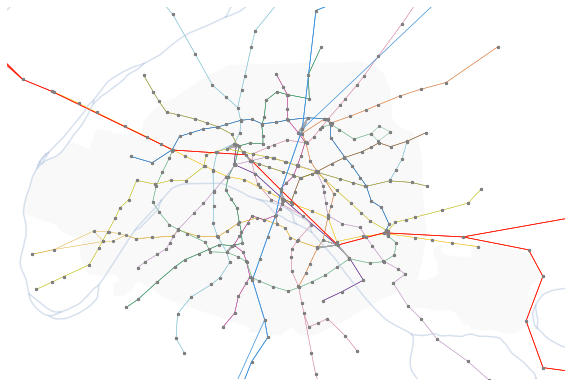

In [40]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 10),
)

# This function is provided together with the graph
plot_ratp(ax, g)

Use Dijkstra's algorithm to find the shortest path between Félix Faure and Robespierre. Consider first that "shortest" means "with the least number of stations".

In [42]:
# %load solutions/shortest_path.py
def shortest_path(g, source, target, method, **kwargs):
    """Finds the shortest path between source and target.

    Since many stations may match source and target, the method
    tries to all pairs and returns the shortest path.

    If errors are met, they are silenced unless no pair yields a
    shortest path.

    Returns a dictionary with various metrics and information
    useful for future explanations.

    """

    best_eval = np.inf
    best_result = None
    latest_exception = None

    for source_ in search_station(source):
        for target_ in search_station(target):
            try:
                with StatsPatch(g) as stats:
                    cur_attempt = method(
                        g, source=source_, target=target_,
                        **kwargs)
                    cur_eval = sum(
                        g[u][v].get(kwargs.get('weight', None), 1)
                        for u, v in zip(cur_attempt[:-1], cur_attempt[1:])
                    )
                    if cur_eval >= best_eval:
                        continue
                    best_eval = cur_eval
                    best_result = cur_attempt
                    best_stats = stats

            except nx.NetworkXNoPath as e:
                latest_exception = e

    if best_result is None:
        if latest_exception is not None:
            raise latest_exception
        return None

    return {
        'weight': best_eval,
        'path': [Station(id_) for id_ in best_result],
        'counter': best_stats.counter,
        'stats': best_stats
    }


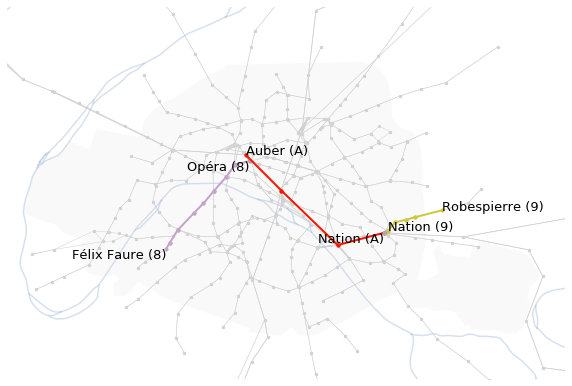

In [43]:
# This visualization code should only be used with the solution provided above.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_ratp(ax, g, color='lightgrey')

plot_path(
    ax, g, shortest_path(
        g, 'Félix Faure', 'Robespierre',
        nx.shortest_paths.dijkstra_path
    )
)

Modify the graph definition to add the distance information and use Dijkstra's algorithm with distance as cost.

In [44]:
# Paris RATP graph definition
# Add now the distance information

g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        for first, second in zip(sequence[:-1], sequence[1:]):
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the graph
        # (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )

In [46]:
def distance(i1, i2):
    x1, y1 = pos[i1]
    x2, y2 = pos[i2]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        for first, second in zip(sequence[:-1], sequence[1:]):
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # add distance information
                distance=distance(first, second),
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the
        # graph (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                distance=distance(first, second),
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                distance=distance(first, second),
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )



/home/max/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


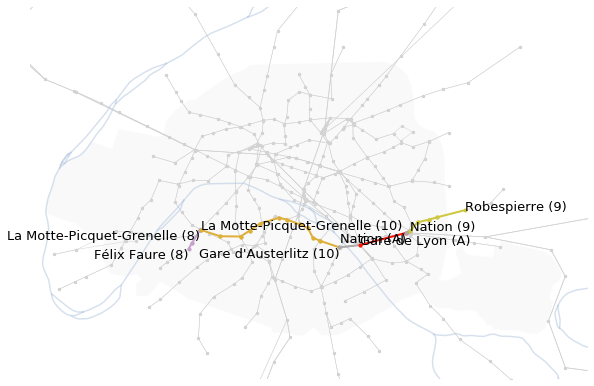

In [47]:
# Plot the solution for Dijkstra's algorithm with distance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_ratp(ax, g, color='lightgrey')
plot_path(
    ax, g, shortest_path(
        g, 'Félix Faure', 'Robespierre',
        nx.shortest_paths.dijkstra_path,
        weight='distance'
    )
)

Use the A* algorithm to find the shortest path between Félix Faure and Robespierre. Read the documentation to find how to implement your heuristic. You should obtain the same shortest path.

In [48]:
%%timeit
shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.dijkstra_path,
    weight='distance'
)

13.4 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%%timeit
shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.astar_path,
    weight='distance',
    heuristic=distance
)

15.5 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
astar = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.astar_path,
    weight='distance',
    heuristic=distance,
)

dijkstra = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    # A* without heuristic is equivalent to Dijkstra
    nx.shortest_paths.astar_path,
    weight='distance',
)

# of course the result is the same!
astar['weight'], dijkstra['weight']

(10826.222635513263, 10826.222635513263)

In [51]:
# Number of nodes explored
astar['counter'], dijkstra['counter']

(127, 664)

Find the ***fastest*** path between Félix Faure and Robespierre. Can we use A\* here?

Keep the heuristic for distances and use A* algorithm anyway.

In [53]:
g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        for first, second in zip(sequence[:-1], sequence[1:]):
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the graph
        # (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )

In [55]:
g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        times = list(
            sum(
                int(a) * 60 ** (2 - i)  # h * 3600 + m * 60 + s
                for i, a in enumerate(times.split(':'))
            )
            for times in (
                    stop_times[line_nb]
                    .query(f'trip_id == {trip_id}')
                    .arrival_time.values
            )
        )

        for first, second, t1, t2 in zip(sequence[:-1], sequence[1:],
                                         times[:-1], times[1:]):
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # add distance information
                distance=distance(first, second),
                # add duration information
                duration=t2 - t1,
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the
        # graph (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                distance=distance(first, second),
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                distance=distance(first, second),
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )



In [56]:
# Run both algorithms and print paths lengths.

dijkstra = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.dijkstra_path,
    weight='duration'
)

astar = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.astar_path,
    weight='duration',
    heuristic=distance
)

# With a wrong heuristic, A* gives nonsense
astar['weight'], dijkstra['weight']

(2660, 1798)

/home/max/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


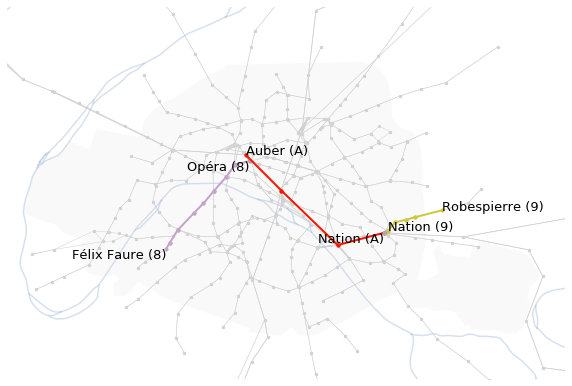

In [57]:
# Display the path found by Dijsktra's algorithm with durations

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_ratp(ax, g, color='lightgrey')
plot_path(ax, g, dijkstra)

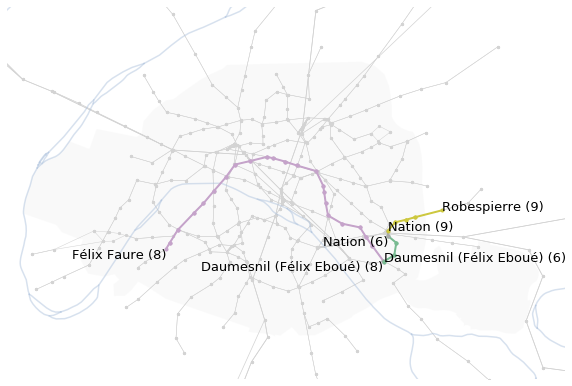

In [58]:
# Display the path found by A* algorithm with durations

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_ratp(ax, g, color='lightgrey')
plot_path(ax, g, astar)